In [38]:
#1. Setup and Initial Loading

import os, json
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from itertools import chain


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

na_like = {"", "na", "n/a", "none", "null", "nil", "nan", ".", "?", "-", "--"}

os.listdir('/content')

# Load the dataset
df = pd.read_csv("FedCycleData071012 (2).csv", na_values=list(na_like), skipinitialspace=True)

print(f"Initial data shape: {df.shape}")




Initial data shape: (1665, 80)


In [39]:
# 2. Data Cleaning and Type Correction

# Correct data types for key columns before processing
df['CycleNumber'] = pd.to_numeric(df['CycleNumber'], errors='coerce')

# coalesce paired columns
pair_fallbacks = [
    ('Age', 'AgeM'),
    ('Maristatus', 'MaristatusM'),
    ('Religion', 'ReligionM'),
    ('Ethnicity', 'EthnicityM'),
    ('Schoolyears', 'SchoolyearsM'),
    ('Medvits', 'MedvitsM'),
    ('Medvitexplain', 'MedvitexplainM'),
    ('Livingkids', 'LivingkidsM'),
    ('Nextpreg', 'NextpregM'),
    ('Spousesame', 'SpousesameM')
]

for primary, fallback in pair_fallbacks:
    if primary in df.columns and fallback in df.columns:
        df[primary] = df[primary].fillna(df[fallback])
        df.drop(columns=fallback, inplace=True)

print("Paired columns coalesced.")

# Sort for feature engineering
df = df.sort_values(['ClientID', 'CycleNumber']).reset_index(drop=True)

print(f"Data shape after sorting and coalescing: {df.shape}")

Paired columns coalesced.
Data shape after sorting and coalescing: (1665, 70)


In [40]:
# 3. Target Variable & Feature Engineering

# Define the Target Variable
df['LengthofCycle'] = pd.to_numeric(df['LengthofCycle'], errors='coerce')
df['next_cycle_length'] = df.groupby('ClientID')['LengthofCycle'].shift(-1)

# Drop rows where the target is missing
df_eng = df.dropna(subset=['next_cycle_length']).copy()

# Time-Series Features
for i in range(1, 4):
    df_eng[f'L{i}_LengthofCycle'] = df_eng.groupby('ClientID')['LengthofCycle'].shift(i)

lag_cols = ['L1_LengthofCycle', 'L2_LengthofCycle', 'L3_LengthofCycle']
df_eng['roll_mean_3_cycles'] = df_eng[lag_cols].mean(axis=1)
df_eng['roll_std_3_cycles'] = df_eng[lag_cols].std(axis=1)

# Text-Based Feature Engineering
if 'Gynosurgeries' in df_eng.columns:
    surg_text = df_eng['Gynosurgeries'].astype(str).str.lower()
    df_eng['had_c_section'] = surg_text.str.contains('c-section|c section|cesarean', regex=True).astype(float)
    df_eng['had_d_and_c'] = surg_text.str.contains('d&c|d & c|d and c', regex=True).astype(float)
    df_eng['had_laparoscopy'] = surg_text.str.contains('laparoscopy|laproscopy', regex=True).astype(float)

# Binary Flags
def is_yes_like(x):
    if pd.isna(x): return np.nan
    return 1.0 if str(x).strip().lower() in {'y', 'yes', 'true', 't', '1'} else 0.0

for col in ['CycleWithPeakorNot', 'IntercourseInFertileWindow', 'UnusualBleeding', 'Breastfeeding']:
    if col in df_eng.columns:
        df_eng[f'{col}_flag'] = df_eng[col].apply(is_yes_like)

# Correct data type for numerically-coded categoricals
cat_as_num_cols = ['Group', 'ReproductiveCategory', 'Maristatus', 'Religion', 'Ethnicity', 'Schoolyears', 'Reprocate', 'Method', 'Prevmethod', 'Whychart']
for col in cat_as_num_cols:
    if col in df_eng.columns:
        # Convert to string to ensure they are treated as categories
        df_eng[col] = pd.to_numeric(df_eng[col], errors='coerce').astype('Int64').astype(str).replace('<NA>', np.nan)

print(f"Data shape after feature engineering: {df_eng.shape}")


Data shape after feature engineering: (1506, 83)


In [41]:
# 4. Column Dropping

# Whitelist of columns to keep even if they have high missingness
WHITELIST = {
    'Age', 'BMI', 'Abortions', 'Miscarriages', 'Numberpreg', 'Livingkids',
    'Gynosurgeries', 'Urosurgeries', 'Medvits', 'Medvitexplain'
}

# Drop columns with > 90% missing data, unless whitelisted
missing_frac = df_eng.isna().mean()
print(missing_frac)
cols_to_drop_missing = missing_frac[(missing_frac > 0.9) & (~missing_frac.index.isin(WHITELIST))].index

# Also drop original flag/text columns and identifiers
cols_to_drop_other = [
    'CycleWithPeakorNot', 'IntercourseInFertileWindow', 'UnusualBleeding', 'Breastfeeding',
    'LengthofCycle', # Original target, now captured in lags
    'CycleNumber' # Identifier
]

all_cols_to_drop = list(cols_to_drop_missing) + [c for c in cols_to_drop_other if c in df_eng.columns]

df_clean = df_eng.drop(columns=all_cols_to_drop)

print(f"Dropped {len(all_cols_to_drop)} columns.")
print(f"Final data shape for EDA: {df_clean.shape}")

print(df_clean.isnull().sum())
df_clean.describe().T


ClientID                           0.000000
CycleNumber                        0.000000
Group                              0.000000
CycleWithPeakorNot                 0.000000
ReproductiveCategory               0.000000
                                     ...   
had_laparoscopy                    0.000000
CycleWithPeakorNot_flag            0.000000
IntercourseInFertileWindow_flag    0.000000
UnusualBleeding_flag               0.011952
Breastfeeding_flag                 0.912351
Length: 83, dtype: float64
Dropped 41 columns.
Final data shape for EDA: (1506, 43)
ClientID                              0
Group                                 0
ReproductiveCategory                  0
EstimatedDayofOvulation             128
LengthofLutealPhase                 128
FirstDayofHigh                      231
TotalNumberofHighDays                10
TotalHighPostPeak                     2
TotalNumberofPeakDays                12
TotalDaysofFertility                 27
TotalFertilityFormula           

,count,mean,std,min,25%,50%,75%,max
EstimatedDayofOvulation,1378.0,15.932511,3.522799,8.000000,14.0000,15.000000,18.000000,29.000000
LengthofLutealPhase,1378.0,13.271408,2.620030,1.000000,12.0000,13.000000,14.000000,41.000000
FirstDayofHigh,1275.0,11.747451,3.235968,5.000000,10.0000,11.000000,13.000000,26.000000
TotalNumberofHighDays,1496.0,4.235294,3.498225,0.000000,2.0000,3.000000,5.000000,22.000000
TotalHighPostPeak,1504.0,0.129654,0.585769,0.000000,0.0000,0.000000,0.000000,7.000000
TotalNumberofPeakDays,1494.0,1.939759,1.206862,0.000000,2.0000,2.000000,2.000000,13.000000
TotalDaysofFertility,1479.0,7.995943,3.210265,0.000000,6.0000,7.000000,9.000000,24.000000
TotalFertilityFormula,1505.0,14.235880,3.934239,6.000000,12.0000,13.000000,16.000000,37.000000
LengthofMenses,1503.0,5.237525,1.255137,2.000000,4.0000,5.000000,6.000000,15.000000
MensesScoreDayOne,1503.0,2.284764,0.779276,1.000000,2.0000,2.000000,3.000000,3.000000


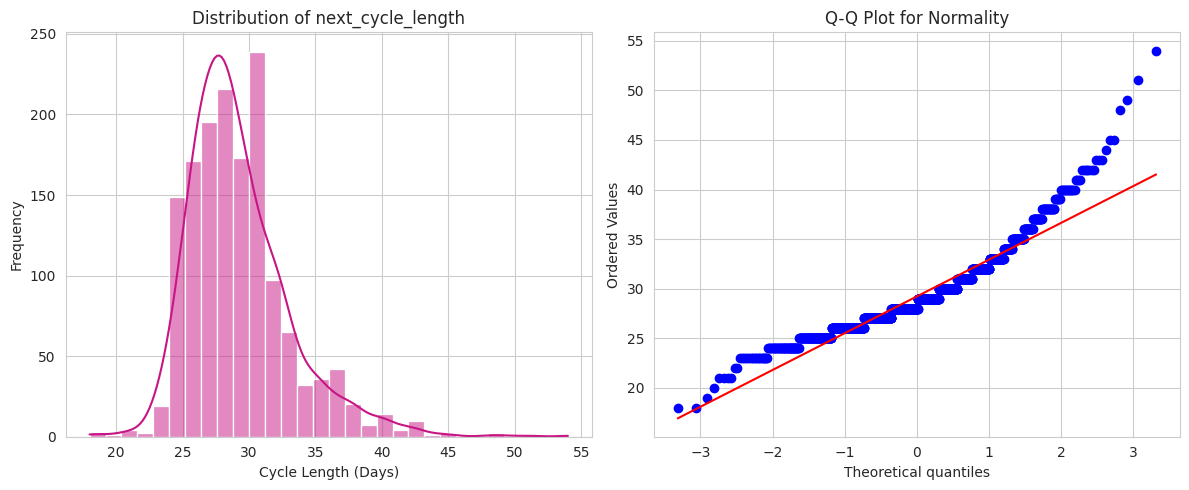

count    1506.000000
mean       29.221116
std         3.874902
min        18.000000
25%        27.000000
50%        28.000000
75%        31.000000
max        54.000000
Name: next_cycle_length, dtype: float64


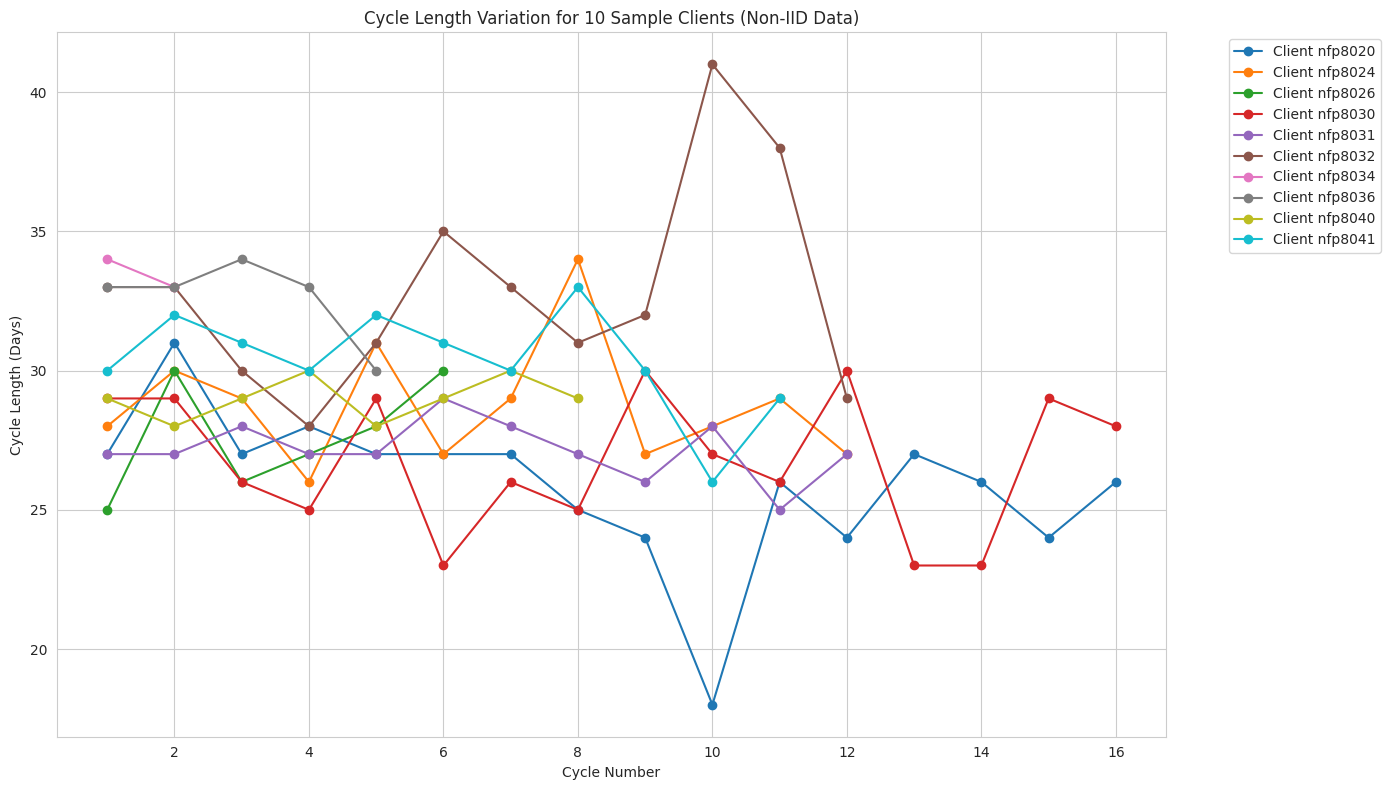

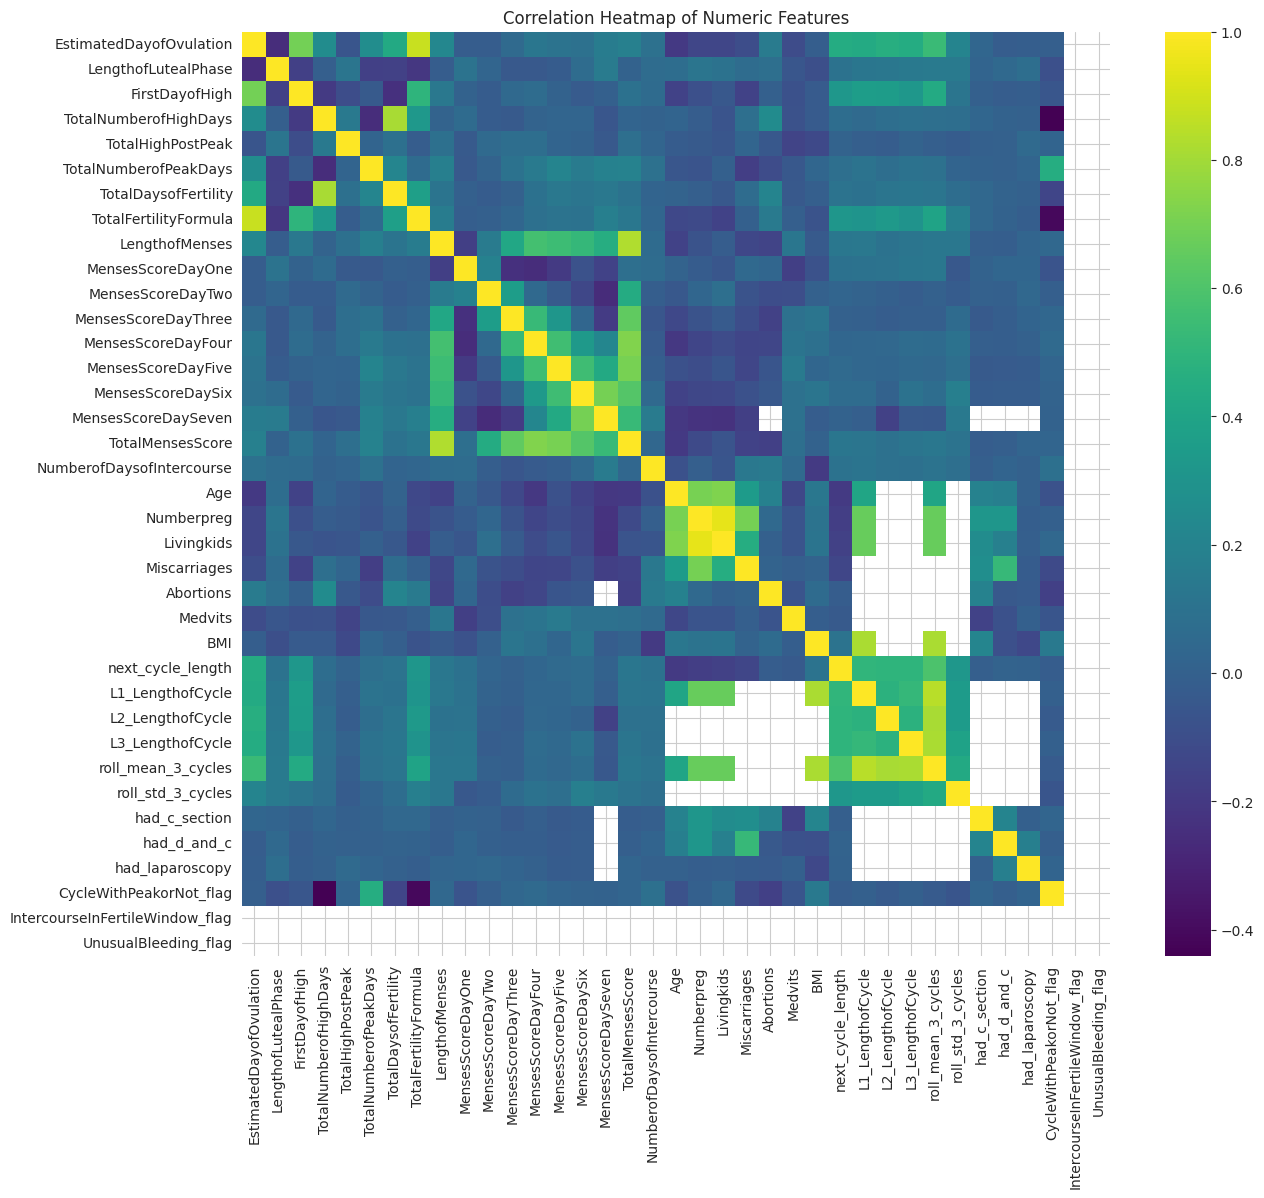

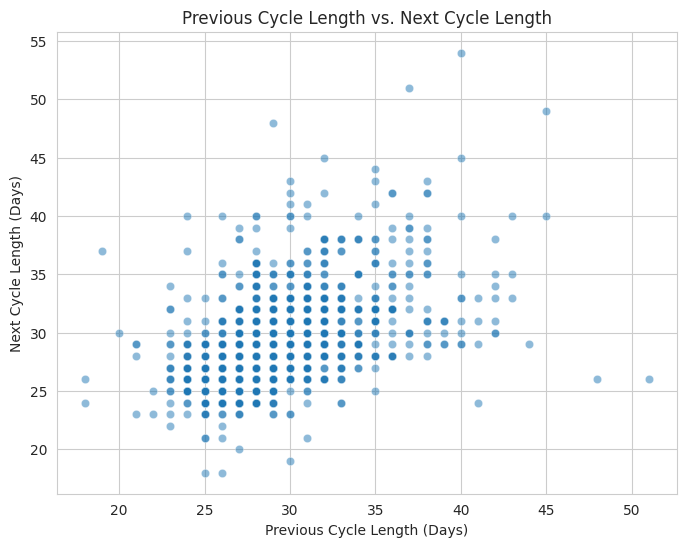

In [42]:
#  5. Exploratory Data Analysis

target = 'next_cycle_length'

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_clean[target], kde=True, bins=30, color='mediumvioletred')
plt.title(f'Distribution of {target}')
plt.xlabel('Cycle Length (Days)')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(df_clean[target], dist="norm", plot=plt)
plt.title('Q-Q Plot for Normality')

plt.tight_layout()
plt.show()

print(df_clean[target].describe())



plt.figure(figsize=(14, 8))
sample_clients = df['ClientID'].unique()[:10]
for client in sample_clients:
    client_data = df[df['ClientID'] == client]
    plt.plot(client_data['CycleNumber'], client_data['LengthofCycle'], marker='o', linestyle='-', label=f'Client {client}')

plt.title('Cycle Length Variation for 10 Sample Clients (Non-IID Data)')
plt.xlabel('Cycle Number')
plt.ylabel('Cycle Length (Days)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


# Feature Relationships

# Correlation Heatmap for Numeric Features
numeric_cols = df_clean.select_dtypes(include=np.number).columns
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='viridis', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Scatter plot of the strongest predictor vs. target
plt.figure(figsize=(8, 6))
sns.scatterplot(x='L1_LengthofCycle', y=target, data=df_clean, alpha=0.5)
plt.title('Previous Cycle Length vs. Next Cycle Length')
plt.xlabel('Previous Cycle Length (Days)')
plt.ylabel('Next Cycle Length (Days)')
plt.grid(True)
plt.show()



In [43]:
# 6. Final Preprocessing for Modeling
from sklearn.preprocessing import FunctionTransformer, RobustScaler

df_final = df_clean.copy()
target = 'next_cycle_length'

# Outlier handling
q_low  = df_final[target].quantile(0.01)
q_high = df_final[target].quantile(0.99)
df_final[target] = df_final[target].clip(lower=q_low, upper=q_high)

# Clip the lag features
for c in ['L1_LengthofCycle', 'L2_LengthofCycle', 'L3_LengthofCycle', 'roll_mean_3_cycles', 'roll_std_3_cycles']:
    if c in df_final:
        lo = df_final[c].quantile(0.01)
        hi = df_final[c].quantile(0.99)
        df_final[c] = df_final[c].clip(lo, hi)



# Define columns to exclude from the feature set
features_to_exclude = [target, 'ClientID']

# Get the list of all potential feature columns
all_features = [col for col in df_final.columns if col not in features_to_exclude]

# Now, separate them into types from this filtered list
numeric_features = [col for col in all_features if pd.api.types.is_numeric_dtype(df_final[col])]
categorical_features = [col for col in all_features if pd.api.types.is_object_dtype(df_final[col]) or pd.api.types.is_categorical_dtype(df_final[col])]
text_features = [col for col in ['Gynosurgeries', 'Urosurgeries', 'Medvitexplain'] if col in all_features]

# Remove text features from other lists if they are present
categorical_features = [c for c in categorical_features if c not in text_features]

print(f"Identified {len(numeric_features)} numeric features.")
print(f"Identified {len(categorical_features)} categorical features.")
print(f"Identified {len(text_features)} text features for vectorization.")


# User-Level Train-Test Split
client_ids = df_final['ClientID'].unique()
train_clients, test_clients = train_test_split(client_ids, test_size=0.2, random_state=42)

train_df = df_final[df_final['ClientID'].isin(train_clients)]
test_df = df_final[df_final['ClientID'].isin(test_clients)]

X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


# Define the transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

X_train['combined_text'] = X_train[text_features].fillna('').agg(' '.join, axis=1)
X_test['combined_text'] = X_test[text_features].fillna('').agg(' '.join, axis=1)
text_features_combined = ['combined_text']

text_transformer_combined = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('squeeze', FunctionTransformer(lambda x: x.ravel(), accept_sparse=False)),
    ('tfidf', TfidfVectorizer(max_features=50, stop_words='english')),
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        # Apply TF-IDF to each text column separately if needed, or combine them first
        ('gyno_text', text_transformer_combined, ['Gynosurgeries'] if 'Gynosurgeries' in text_features else []),
        ('uro_text', text_transformer_combined, ['Urosurgeries'] if 'Urosurgeries' in text_features else []),
        ('med_text', text_transformer_combined, ['Medvitexplain'] if 'Medvitexplain' in text_features else [])
    ], remainder='drop'
)


# Separate features (X) and target (y)
X = df_final.drop(columns=[target])
y = df_final[target]

# Apply the transformations
X_processed = preprocessor.fit_transform(X)

print(f"Final processed feature matrix shape: {X_processed.shape}")
print(f"Final target vector shape: {y.shape}")



Identified 36 numeric features.
Identified 2 categorical features.
Identified 3 text features for vectorization.
Training set shape: (1157, 42)
Testing set shape: (349, 42)
Final processed feature matrix shape: (1506, 155)
Final target vector shape: (1506,)


/tmp/ipython-input-1560475494.py:29: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  categorical_features = [col for col in all_features if pd.api.types.is_object_dtype(df_final[col]) or pd.api.types.is_categorical_dtype(df_final[col])]


In [44]:
# # Train and Evaluate Baseline Models

# Model 1: Ridge Regression (Linear Baseline)
print("Training Ridge Regression Baseline")
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
print(f"Ridge Regression Results:")
print(f"  RMSE: {rmse_ridge:.4f}")
print(f"  MAE:  {mae_ridge:.4f}")

# Model 2: Random Forest Regressor (Ensemble Baseline)
print("Training Random Forest Baseline")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest Results:")
print(f"  RMSE: {rmse_rf:.4f}")
print(f"  MAE:  {mae_rf:.4f}")

# Model 3
# Train and Evaluate XGBoost Model
print("Training XGBoost Baseline")
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1,
                                   learning_rate=0.1, max_depth=5))
])

# Train the pipeline
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate the model
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost Results:")
print(f"  RMSE: {rmse_xgb:.4f}")
print(f"  MAE:  {mae_xgb:.4f}")

Training Ridge Regression Baseline
Ridge Regression Results:
  RMSE: 3.1117
  MAE:  2.2606
Training Random Forest Baseline
Random Forest Results:
  RMSE: 3.1200
  MAE:  2.2778
Training XGBoost Baseline
XGBoost Results:
  RMSE: 3.1404
  MAE:  2.2442


/tmp/ipython-input-2380364842.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="RMSE", palette="viridis")


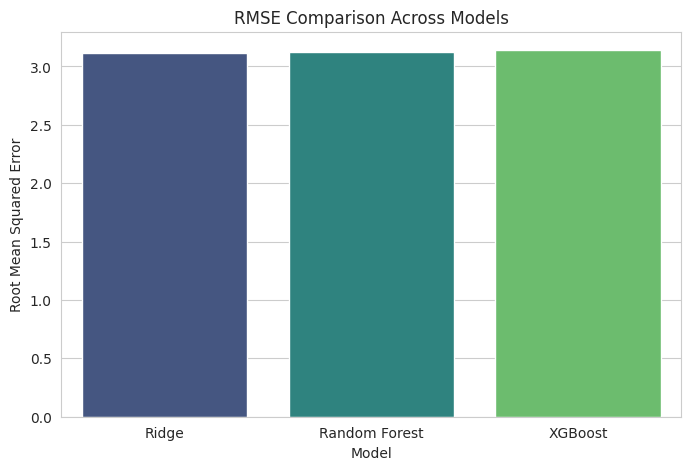

/tmp/ipython-input-2380364842.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results, x="Model", y="MAE", palette="magma")


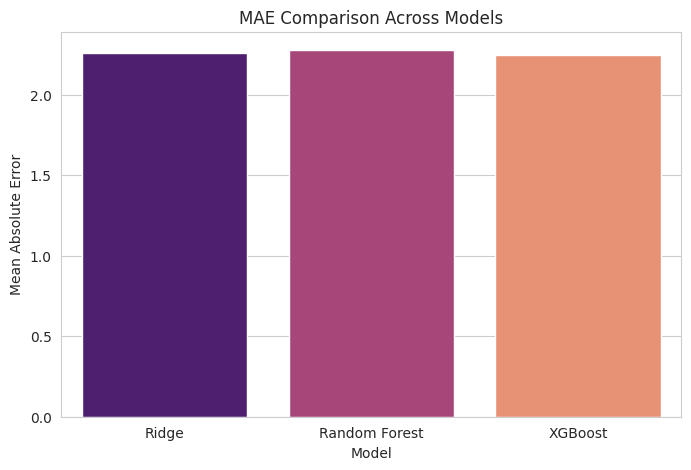

           Model      RMSE       MAE
0          Ridge  3.111664  2.260636
1  Random Forest  3.119961  2.277822
2        XGBoost  3.140370  2.244192


In [45]:
results = pd.DataFrame({
    "Model": ["Ridge", "Random Forest", "XGBoost"],
    "RMSE": [rmse_ridge, rmse_rf, rmse_xgb],
    "MAE":  [mae_ridge,  mae_rf,  mae_xgb ],
})

# Plot RMSE
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison Across Models")
plt.ylabel("Root Mean Squared Error")
plt.show()

# Plot MAE
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Model", y="MAE", palette="magma")
plt.title("MAE Comparison Across Models")
plt.ylabel("Mean Absolute Error")
plt.show()

print(results)


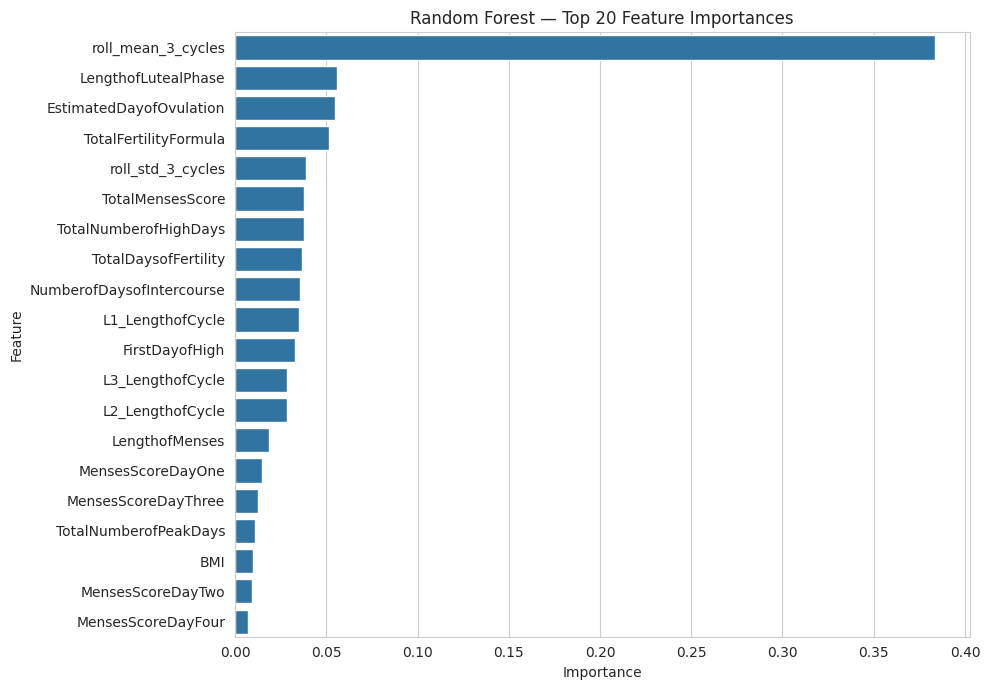

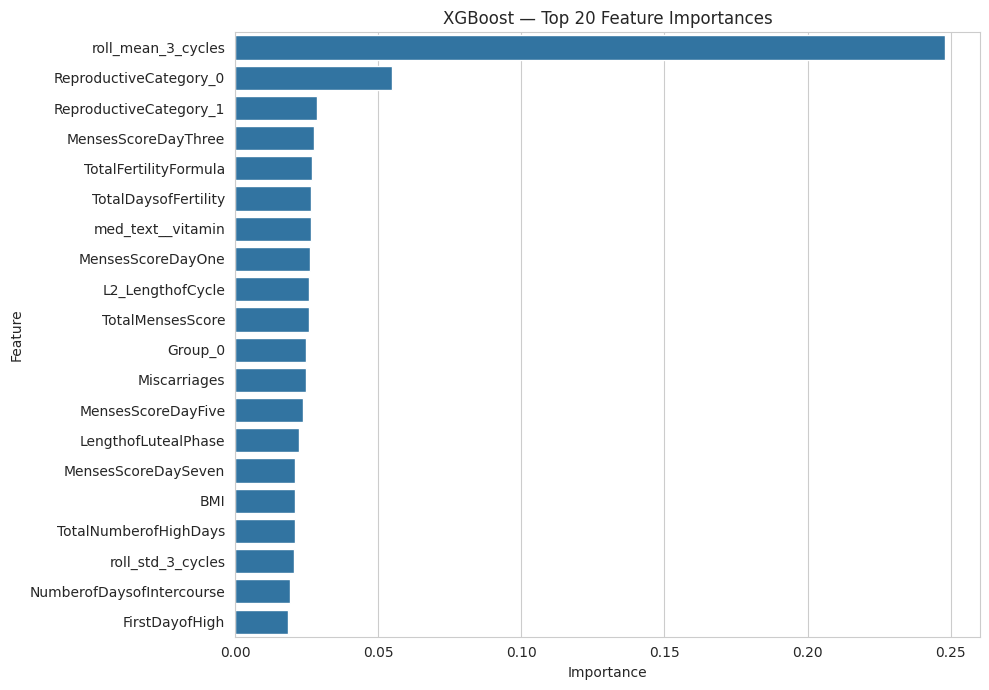

In [46]:
# Feature Importance

def get_feature_names_from_preprocessor(fitted_preprocessor):
    names = []

    # Numeric columns (pass-through after scaler)
    num_cols = fitted_preprocessor.transformers_[0][2]
    names.extend(list(num_cols))

    # Categorical one-hot columns
    cat_cols = fitted_preprocessor.transformers_[1][2]
    ohe = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_cols)
    names.extend(list(cat_names))

    # Text TF-IDF columns
    for tname in ['gyno_text', 'uro_text', 'med_text']:
        sub = fitted_preprocessor.named_transformers_.get(tname, 'drop')
        if sub == 'drop' or sub == 'passthrough':
            continue
        # Pull the TF-IDF step
        tfidf = sub.named_steps['tfidf']
        vocab = tfidf.get_feature_names_out()
        # Prefix with the transformer name
        text_feature_names = [f"{tname}__{v}" for v in vocab]
        names.extend(text_feature_names)

    return np.array(names)

# Use the preprocessor
fitted_pre = rf_pipeline.named_steps['preprocessor']
feature_names = get_feature_names_from_preprocessor(fitted_pre)

# Plots
# Random Forest
importances_rf = rf_pipeline.named_steps['regressor'].feature_importances_
rf_importances = pd.Series(importances_rf, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(x=rf_importances.values, y=rf_importances.index)
plt.title("Random Forest — Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# XGBoost
importances_xgb = xgb_pipeline.named_steps['regressor'].feature_importances_
xgb_importances = pd.Series(importances_xgb, index=feature_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(x=xgb_importances.values, y=xgb_importances.index)
plt.title("XGBoost — Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()